# Load TF, TFIDF and data

In [1]:
from utils import load_data
from joblib import load

n_topics = [3, 5, 7, 10, 20, 27, 30]
n_docs = 10000
n_top_words = 10
textPre_FilePath = "../data/readme_corpus.txt"
tf_ModelPath = "../readme_model/tf.pt"
tfidf_ModelPath = "../readme_model/tfidf.pt"
lda_ModelPath = "../readme_model/"

docLst = load_data(textPre_FilePath)[:n_docs]
tfidf_vectorizer = load(tfidf_ModelPath)
tf_vectorizer = load(tf_ModelPath)
tf = tf_vectorizer.transform(docLst)
tfidf = tfidf_vectorizer.transform(tf)

# Load LDA model and print the top words of each topic

In [2]:
from utils import print_top_words
from joblib import load
n_t = 2
lda = load(lda_ModelPath + "lda_" + str(n_topics[n_t]) + ".pt")
print("Perplexity:", lda.perplexity(tfidf))
print("Score:", lda.score(tfidf))
tf_feature_names = tf_vectorizer.get_feature_names_out()
topic_word = print_top_words(lda, tf_feature_names, n_top_words)

Perplexity: 366.6615235404535
Score: -192722.6659557183
Topic #0:
facebook function tf graph evalu predict gener learn machin packag
Topic #1:
word languag sentenc sw blob task question transform torch timm
Topic #2:
darknet batch sh config estim chang gpu facebook comput json
Topic #3:
doc segment md torch readm badg domain recognit architectur vision
Topic #4:
loss size layer benchmark clip resnet coco output label rate
Topic #5:
googl environ view video folder directori licens citat id experi
Topic #6:
base shield text img io licens master packag sourc vit


# Visualization

In [10]:
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
pic = pyLDAvis.lda_model.prepare(lda, tfidf, tf_vectorizer)
pyLDAvis.save_html(pic, 'lda_readme_pass'+str(n_topics[n_t]) + '.html')
pyLDAvis.display(pic)

# Predict topic for each sample

In [3]:
import pandas as pd
import numpy as np


rows = []
for idx, doc in enumerate(tfidf):
    distribution = lda.transform(doc)
    topic_id = np.argmax(distribution)
    data = [docLst[idx], distribution, topic_id]
    rows.append(data)

doc_topic = pd.DataFrame(rows, columns=['doc', 'distribution', 'topic'])
doc_topic

,doc,distribution,topic
0,espa ol state art machin pytorch transform tho...,"[[0.033508287925820515, 0.034431514808455764, ...",3
1,infer pre model infer step contain gpu dockerf...,"[[0.04668198527626086, 0.04679072549088589, 0....",2
2,repositori apprais http github com appraisedev...,"[[0.516431375745179, 0.3287210035059262, 0.029...",0
3,introduct theano kaldi rnn softwar possibl use...,"[[0.7907155312694097, 0.03115587236194062, 0.0...",0
4,knn swin k neighbor implement k neighbor imple...,"[[0.07170968811929467, 0.07161925917493375, 0....",6
...,...,...,...
9995,error covari kalmannet model src path line pat...,"[[0.6435101412994181, 0.05950818255662431, 0.0...",0
9996,student model knowledg distil link http arxiv ...,"[[0.0428847677167584, 0.042888400219643734, 0....",5
9997,space time video network repositori stvun pape...,"[[0.03011368597795252, 0.030170661197895608, 0...",6
9998,coroica matlab pleas refer project http sweich...,"[[0.5697894935806203, 0.07172060742096005, 0.0...",0


# Evaluate the LDA model

## Silhouette Coefficient

In [4]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(tfidf, doc_topic['topic'])
# 1 is best
print("The average Silhouette Coefficient is:", silhouette_avg)

The average Silhouette Coefficient is: 0.01756419393898945


## Davies-Bouldin Index

In [5]:
from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(tfidf.toarray(), doc_topic['topic'])

print("The Davies-Bouldin Index is:", db_index)

The Davies-Bouldin Index is: 6.082893228786719


## Calinski-Harabasz Index

In [6]:
from sklearn.metrics import calinski_harabasz_score
ch_index = calinski_harabasz_score(tfidf.toarray(), doc_topic['topic'])

print("The Calinski-Harabasz Index is:", ch_index)

The Calinski-Harabasz Index is: 92.94204387656718


## Evaluation

In [7]:
def evaluate(X, labels, lda):
    silhouette_avg = silhouette_score(X, labels)
    db_index = davies_bouldin_score(X.toarray(), labels)
    ch_index = calinski_harabasz_score(X.toarray(), labels)
    return [lda, silhouette_avg, db_index, ch_index]
    
performance = []
for n_t in n_topics:
    lda = load(lda_ModelPath + "lda_" + str(n_t) + ".pt")
    rows = []
    for idx, doc in enumerate(tfidf):
        distribution = lda.transform(doc)
        topic_id = np.argmax(distribution)
        data = [docLst[idx], distribution, topic_id]
        rows.append(data)
    doc_topic = pd.DataFrame(rows, columns=['doc', 'distribution', 'topic'])
    performance.append(evaluate(tfidf, doc_topic['topic'], "lda_"+str(n_t)))

performance = pd.DataFrame(performance, columns=['Model', 'Silhouette Coefficient', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])
performance

,Model,Silhouette Coefficient,Davies-Bouldin Index,Calinski-Harabasz Index
0,lda_3,0.009265,7.362897,114.506023
1,lda_5,0.008996,6.278808,101.677888
2,lda_7,0.017564,6.082893,92.942044
3,lda_10,0.031191,4.529037,114.879504
4,lda_20,0.023700,3.920453,89.857928
5,lda_27,-0.062191,3.448946,84.976428
6,lda_30,0.034733,3.503857,79.594159


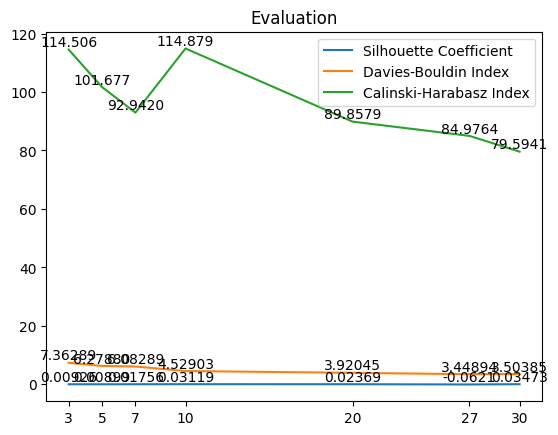

In [8]:
import matplotlib.pyplot as plt
plt.figure()
measures = ['Silhouette Coefficient', 'Davies-Bouldin Index', 'Calinski-Harabasz Index']
for measure in measures:
    plt.plot(n_topics, np.array(performance[measure]), label=measure)
    for i in range(len(n_topics)):
        plt.text(n_topics[i], performance[measure][i], str(performance[measure][i])[:7], ha='center', va='bottom')
plt.xticks(n_topics) 
plt.title('Evaluation')
plt.legend()
plt.show()